For our final project, we have chosen to analyze Spotify music data, focusing on key attributes of songs. This dataset comprises various features, including track duration, explicit content, danceability, energy, and more.

Our central question revolves around predicting the popularity of a song based on its musical characteristics and qualities. Specifically, we aim to investigate the following:

Can we predict the popularity of a song based on musical characteristics/qualities? What qualities of a song contribute the most to its popularity?

The motivation and value behind this question is to provide valuable insights for recording companies and artists, offering a greater understanding of the factors that influence a song's popularity. By determining which musical attributes contribute significantly to a song's success, stakeholders can make informed decisions to enhance the appeal and marketability of their music. 

Our question is relevant to the music industry, where the ability to predict a song's popularity directly impacts revenue generation.


We found our dataset on this website: https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset/tree/main 

The columns that we are working with to analyze are as follows: 
name
album
artist
id
release_date
popularity
length
danceability
acousticness
energy
instrumentalness
liveness
valence
loudness
speechiness
tempo
key
time_signature
mood

In [83]:
# step 1: import the libraries and upload the dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from lime import lime_tabular
from sklearn.inspection import permutation_importance
#below is a new package needed for this lab
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder

# open the dataset.csv file 
music = pd.read_csv('dataset.csv')
# inspect the types of each column
music.dtypes


Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

We decided that the best model to use for our question would be Random forest. This is because we have alot of key features that are both numerical and categorical. 

We want to use random forest to be able to determine what factors contribute the most to popularity. RF is an adequate model for our question because they work with both numerical and categorical data, flexible, and easy to interpret.



First, lets clean our data set a little bit for manipulation. 

In [84]:
# check how many nas 
music.isna().sum()
# not too many nas, so we can drop them 
music = music.dropna()


Lets do some exploratory data analysis on the data

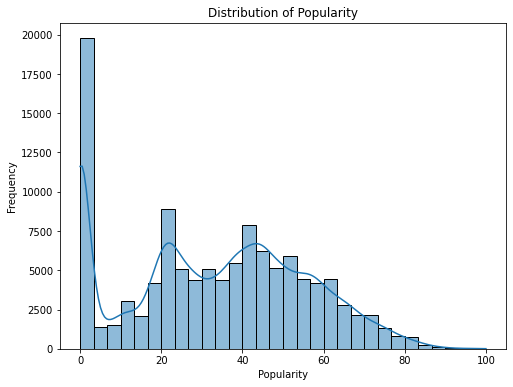

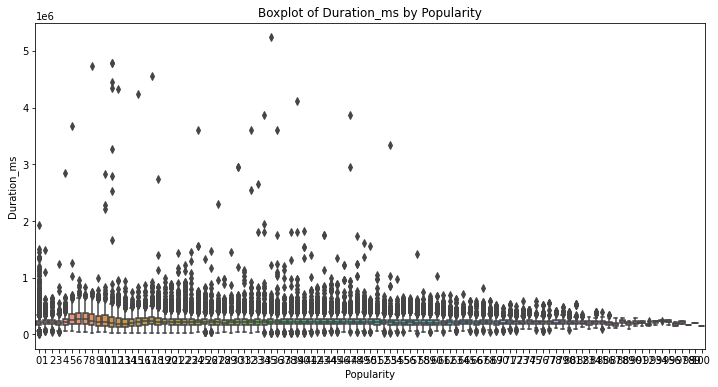

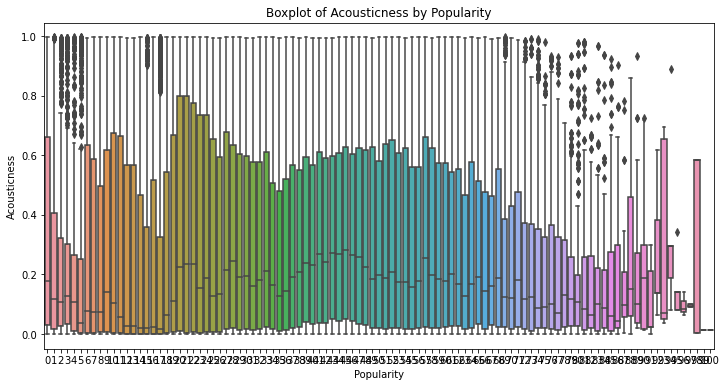

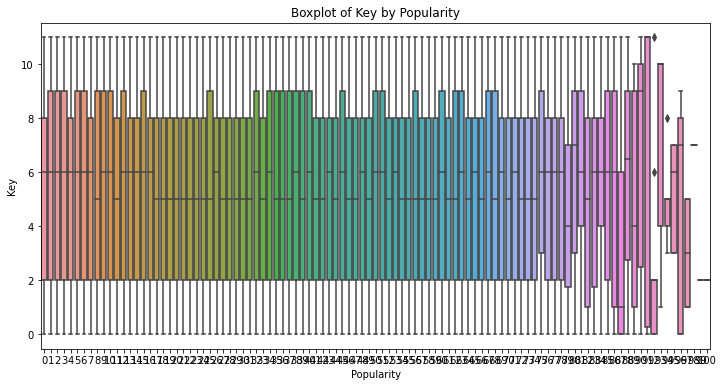

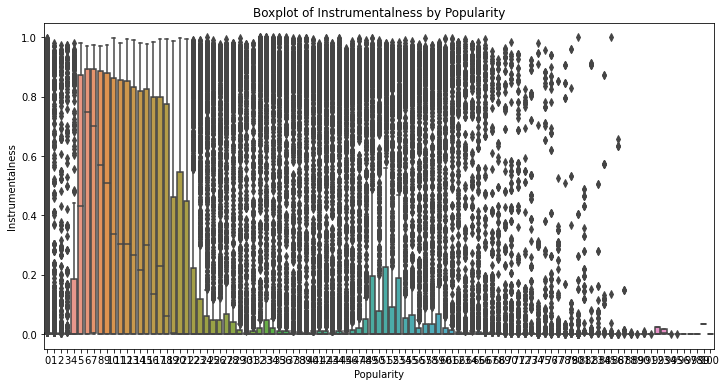

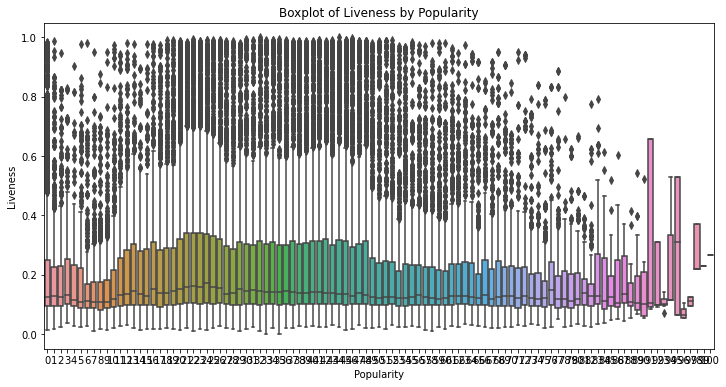

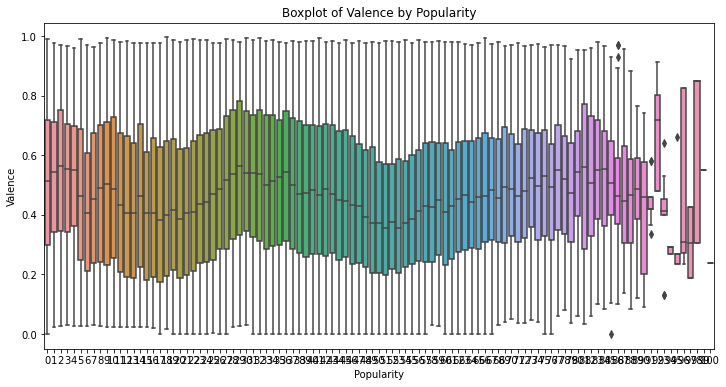

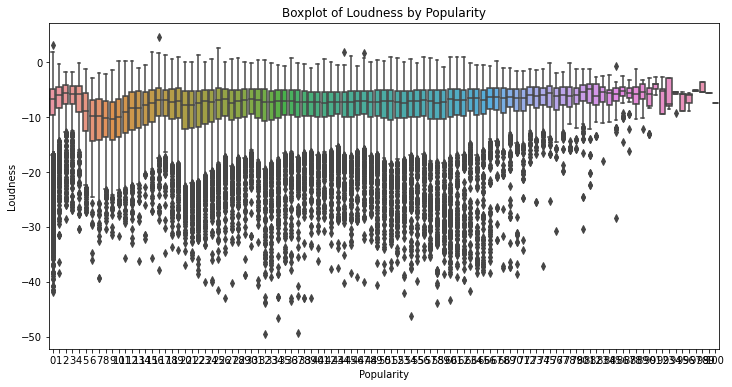

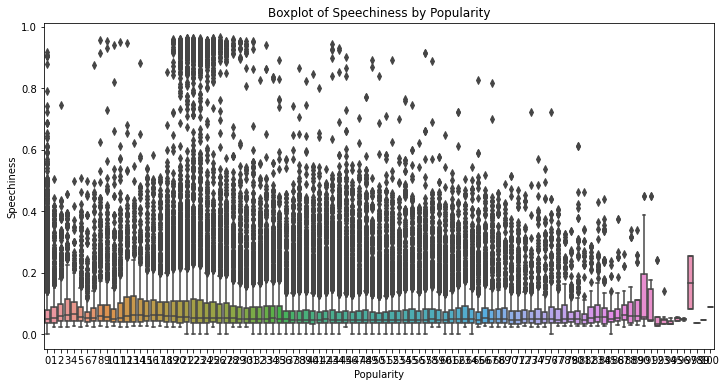

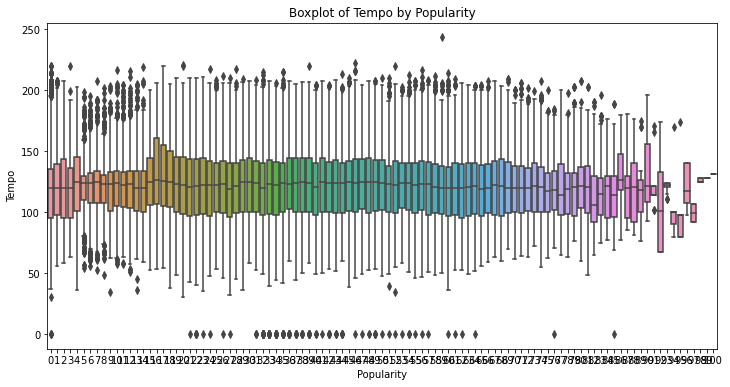

In [85]:

import seaborn as sns


# Distribution of the target variable (popularity)
plt.figure(figsize=(8, 6))
sns.histplot(music["popularity"], bins=30, kde=True)
plt.title("Distribution of Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()
# you can see from this that there are alot more unpopular songs than popular
# this could lead to skewed results later on 


# List of numerical variables related to popularity
numerical_variables = ["duration_ms", "acousticness", "key", "instrumentalness",
                        "liveness", "valence", "loudness", "speechiness", "tempo"]

# Create boxplots for each numerical variable
for variable in numerical_variables:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="popularity", y=variable, data=music)
    plt.title(f"Boxplot of {variable.capitalize()} by Popularity")
    plt.xlabel("Popularity")
    plt.ylabel(variable.capitalize())
    plt.show()

# we can see some initial trends --> the longer the song the less popular it is 
# acousticness varies 
# hgiher key leads to highest popularity 
# less instrumental = more popular


In [86]:
# lets fix some of the columns values --> example some of the track names are not legible
# lets remove the ones that are not in english, with any letters that contain special symbols 
# in another language other than english 
music = music[music['track_name'].str.contains('^[a-zA-Z ]+$')]
music['track_name'].value_counts()
# lets drop track_id because it is just a bunch of letters 
music = music.drop(['track_id'], axis = 1)
# also remove the unnamed column
music = music.drop(['Unnamed: 0'], axis = 1)
# lets also drop album name because this wont really contribute to popularity 
music = music.drop(['album_name'], axis = 1)
# lets also drop artists since we dont have any tell about the artists popularity/fame 
music = music.drop(['artists'], axis = 1)
# lets also drop the track name because this wont really contribute to popularity
music = music.drop(['track_name'], axis = 1)
# we want to be able to predict popularity of the track, so maybe we can add this in later 



In [87]:
# before doing that, lets separate our X and Y variables for our random forest 
# we will use the popularity as our target variable
y = music['popularity']
X = music.drop(['popularity'], axis = 1)


In [88]:
# rifht now popularity is on a 0-100 scale, lets change it to a more condensed scale 
# lets use either not popular or popular 
# the cutoff is 0-50 and then 50-100

# lets create a function that will change the popularity to either 0 or 1
def popularity_change(popularity):
    if popularity < 50:
        return 0
    else:
        return 1

# lets apply this function to our y variable
y = y.apply(popularity_change)



In [89]:
# preprocessing --> turn objects to categorical 

X['track_genre']= X['track_genre'].astype('category') 


In [90]:
# one hot encode the categorical variable --> its only genre -- which could predict popularity 

category_list = list(X.select_dtypes('category')) #select function to find the categorical variables and create a list  

X_1h = pd.get_dummies(X, columns = category_list) 
X_1h.info()

X= X_1h


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68607 entries, 0 to 113999
Columns: 128 entries, duration_ms to track_genre_world-music
dtypes: bool(1), float64(9), int64(4), uint8(114)
memory usage: 14.9 MB


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify= y, random_state=21) 
#start with 10% of our dataset, could do 20% but random forest does require more training data
#because of the sampling so 90% might be a better approach with this small of a dataset
#remember, use random_state to create reproducible results


In [92]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())


0    44792
1    16954
Name: popularity, dtype: int64
0    4977
1    1884
Name: popularity, dtype: int64


In [93]:

random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }


In [94]:

print('max_features = ' + str(np.sqrt(X.shape[1]))) #around 4

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

song_RF= RFC.fit(X_train,y_train)



max_features = 11.313708498984761


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


In [95]:
print('OOB error rate: ' + str(1-song_RF.oob_score_))
# 27% error rate, not bad


OOB error rate: 0.27457649078482815


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.1s finished


0.7254235092151718

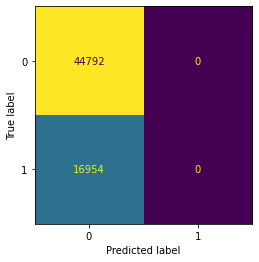

In [96]:
#Call up the confusion matrix and check the accuracy of the model.
ConfusionMatrixDisplay.from_estimator(song_RF,X_train,y_train, colorbar= False)
# we have ALOT of incorrect predictions for under 50k, but we have a lot of data for that category


song_RF.score(X_train,y_train) 
# 80% accurate, not terrible 
# confusion matrix shows that the predicted 


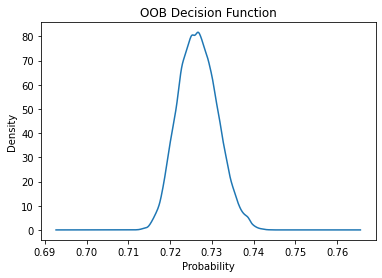

In [97]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 50k
xx = pd.DataFrame(song_RF.oob_decision_function_)


#Create a density plot of the positive class probabilities and comment on the pattern you see.
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

# density is highest at .72/73 probability 
# predicting alot of medium popularity songs 


In [98]:


np.argmax(song_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(song_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))



                         importance
tempo                      0.099806
valence                    0.091672
key                        0.083924
energy                     0.080130
duration_ms                0.078531
...                             ...
track_genre_forro          0.000000
track_genre_emo            0.000000
track_genre_electro        0.000000
track_genre_edm            0.000000
track_genre_world-music    0.000000

[128 rows x 1 columns]
